<a href="https://colab.research.google.com/github/gani88/CrackDetectionInPainting/blob/main/CrackDetectionPainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Unzip File Dataset
import zipfile

local_zip = '/content/PaintingDataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [ ]:
import os

base_dir = '/content/Painting Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Training'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Validation'))

Contents of base directory:
['Validation', 'Training']

Contents of train directory:
['NonCrack', 'Crack']

Contents of validation directory:
['NonCrack', 'Crack']


In [ ]:
import os

train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with training cat/dog pictures
train_noncrack_dir = os.path.join(train_dir, 'NonCrack')
train_crack_dir = os.path.join(train_dir, 'Crack')

# Directory with validation cat/dog pictures
validation_noncrack_dir = os.path.join(validation_dir, 'NonCrack')
validation_crack_dir = os.path.join(validation_dir, 'Crack')

In [ ]:
train_noncrack_fnames = os.listdir( train_noncrack_dir )
train_crack_fnames = os.listdir( train_crack_dir )

print("Non Crack Painting : ", train_noncrack_fnames[:10])
print("Crack Painting : ", train_crack_fnames[:10])

Non Crack Painting :  ['0015.jpg', '0039.jpg', '0164.jpg', '0236.jpg', '0229.jpg', '0072.jpg', '0430.jpg', '0227.jpg', '0210.jpg', '0149.jpg']
Crack Painting :  ['5miracle.jpg', '081madon.jpg', '01holyfb.jpg', '10leave1.jpg', '8jerome2.jpg', '196madon.jpg', '01crucif.jpg', '4ermine1.jpg', 'mascoli2.jpg', '05farne2.jpg']


In [ ]:
print('total training NonCrack images :', len(os.listdir(      train_noncrack_dir ) ))
print('total training Crack images :', len(os.listdir(      train_crack_dir ) ))

print('total validation NonCrack images :', len(os.listdir( validation_noncrack_dir ) ))
print('total validation Crack images :', len(os.listdir( validation_crack_dir ) ))

total training NonCrack images : 240
total training Crack images : 240
total validation NonCrack images : 60
total validation Crack images : 60


In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

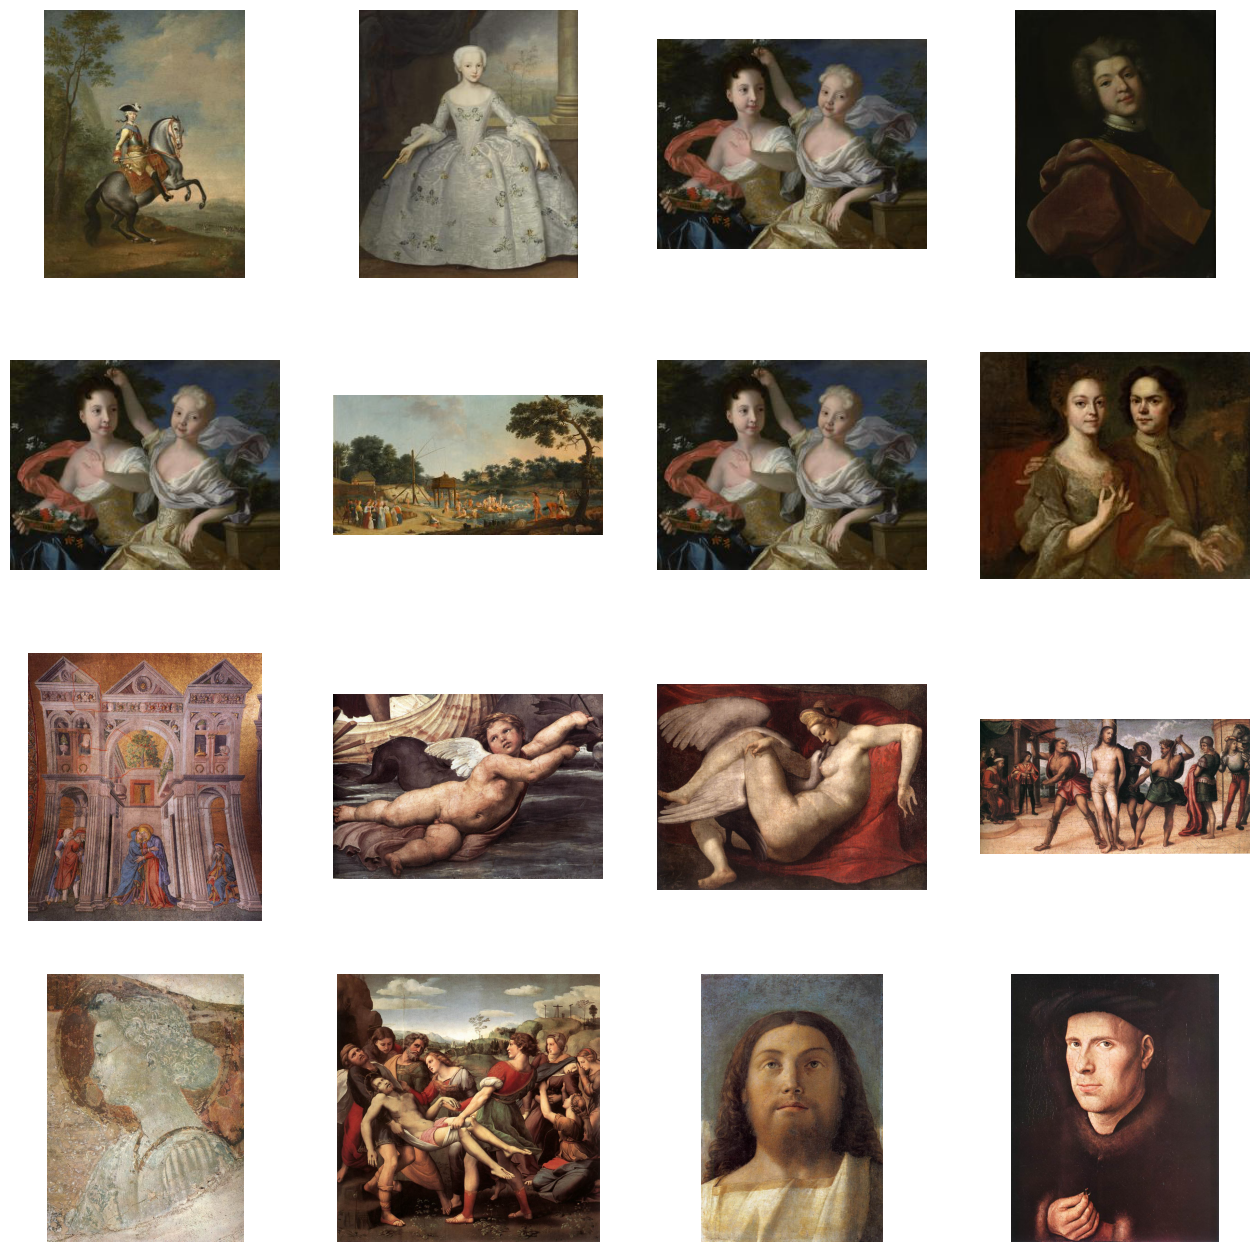

In [13]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_noncrack_pix = [os.path.join(train_noncrack_dir, fname) 
                for fname in train_noncrack_fnames[ pic_index-8:pic_index] 
               ]

next_crack_pix = [os.path.join(train_crack_dir, fname) 
                for fname in train_crack_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_noncrack_pix+next_crack_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [14]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [16]:
# Model
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('noncrack') and 1 for the other ('crack')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [19]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
24/24 - 17s - loss: 0.7955 - accuracy: 0.6458 - val_loss: 0.5436 - val_accuracy: 0.7167 - 17s/epoch - 697ms/step
Epoch 2/15
24/24 - 5s - loss: 0.4714 - accuracy: 0.8083 - val_loss: 0.2889 - val_accuracy: 0.9333 - 5s/epoch - 202ms/step
Epoch 3/15
24/24 - 5s - loss: 0.2217 - accuracy: 0.9312 - val_loss: 0.1031 - val_accuracy: 0.9750 - 5s/epoch - 199ms/step
Epoch 4/15
24/24 - 4s - loss: 0.1825 - accuracy: 0.9229 - val_loss: 0.0683 - val_accuracy: 0.9833 - 4s/epoch - 187ms/step
Epoch 5/15
24/24 - 5s - loss: 0.1292 - accuracy: 0.9438 - val_loss: 0.0541 - val_accuracy: 0.9833 - 5s/epoch - 225ms/step
Epoch 6/15
24/24 - 4s - loss: 0.0909 - accuracy: 0.9688 - val_loss: 0.0449 - val_accuracy: 0.9917 - 4s/epoch - 185ms/step
Epoch 7/15
24/24 - 5s - loss: 0.0697 - accuracy: 0.9750 - val_loss: 0.2697 - val_accuracy: 0.9250 - 5s/epoch - 203ms/step
Epoch 8/15
24/24 - 5s - loss: 0.1196 - accuracy: 0.9625 - val_loss: 0.0357 - val_accuracy: 0.9833 - 5s/epoch - 204ms/step
Epoch 9/15
24/24 - 4s 

In [30]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a noncrack")
  else:
    print(fn + " is a crack")

Saving 0089.jpg to 0089.jpg
1/1 [==============================] - 0s 17ms/step
[0.9998357]
0089.jpg is a noncrack
